In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from textwrap import wrap
import os
import json

from collections import defaultdict

In [6]:
res_total=[]
dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_train"
topo_type="_topology_flows"
data_list=[]
# sampled_list=np.random.choice(np.arange(4000),100,replace=False)
sampled_list=np.arange(4000)
for shard in sampled_list:
    for n_flows in [2000]:
        for n_hosts in [32]:
            for sample in [0]:
                topo_type_cur=topo_type
                spec=f"{shard}/ns3"
                try:
                    fid = np.load(f"{dir_input}/{spec}/fid{topo_type_cur}.npy")
                    if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid)%n_flows==0:
                        data_list.append((spec,(0,n_hosts-1),topo_type_cur))
                    # else:
                    #     print(f"{spec}: {len(fid)}")
                except:
                    continue
               
print(len(data_list))

res_n_flows_active=[]
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    
    arrival_events = np.column_stack((fat, np.ones_like(fat)))  # +1 for each arrival
    completion_events = np.column_stack((fct, -np.ones_like(fct)))  # -1 for each completion

    # Combine events and sort by time
    all_events = np.vstack((arrival_events, completion_events))
    all_events = all_events[all_events[:, 0].argsort()]  # Sort by time
    
    times = all_events[:, 0]
    flow_changes = all_events[:, 1]
    active_flows = np.cumsum(flow_changes)

    res_n_flows_active.append(active_flows)
res_total.append(res_n_flows_active)
  
dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_test_8k"
n_flows=80000
topo_type="_topology_flows"
data_list=[]
for shard in np.arange(100):
    for n_hosts in [32]:
        spec=f"{shard}/ns3"
        fid_path=f"{dir_input}/{spec}/fid{topo_type}.npy"
        if os.path.exists(fid_path):
            fid = np.load(f"{dir_input}/{spec}/fid{topo_type}.npy")
            if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]):
                data_list.append((spec,(0,n_hosts-1),topo_type))
            # else:
            #     print(f"{spec}: {len(fid)}")
               
print(len(data_list))

res_n_flows_active=np.zeros((len(data_list),n_flows*2))
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    
    arrival_events = np.column_stack((fat, np.ones_like(fat)))  # +1 for each arrival
    completion_events = np.column_stack((fct, -np.ones_like(fct)))  # -1 for each completion

    # Combine events and sort by time
    all_events = np.vstack((arrival_events, completion_events))
    all_events = all_events[all_events[:, 0].argsort()]  # Sort by time
    
    times = all_events[:, 0]
    flow_changes = all_events[:, 1]
    active_flows = np.cumsum(flow_changes)

    res_n_flows_active[spec_idx,:len(active_flows)]=active_flows
   
res_n_flows_active=np.array(res_n_flows_active)
print(res_n_flows_active.shape)
res_total.append(res_n_flows_active)

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_train"
data_path="/data2/lichenni/output_perflow/final_param_shard4000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/data_list.json"
data_list=json.load(open(data_path))
data_list=data_list["train"]
flow_size_threshold=100000000
res_n_flows_active=[]
for spec_idx,(spec,src_dst_pair_target,topo_type,segment_id,_) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    busy_periods=np.load(
        f"{dir_input_tmp}/period{topo_type}_t{flow_size_threshold}.npy",
        allow_pickle=True,
    )
    fid=np.array(busy_periods[segment_id])
    
    fat = np.load(f"{dir_input_tmp}/fat.npy")[fid]
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')[fid]
    
    arrival_events = np.column_stack((fat, np.ones_like(fat)))  # +1 for each arrival
    completion_events = np.column_stack((fct, -np.ones_like(fct)))  # -1 for each completion

    # Combine events and sort by time
    all_events = np.vstack((arrival_events, completion_events))
    all_events = all_events[all_events[:, 0].argsort()]  # Sort by time
    
    times = all_events[:, 0]
    flow_changes = all_events[:, 1]
    active_flows = np.cumsum(flow_changes)

    res_n_flows_active.append(active_flows)
res_total.append(res_n_flows_active)

3940
94
(94, 160000)


/tmp/ipykernel_1215483/2822369300.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


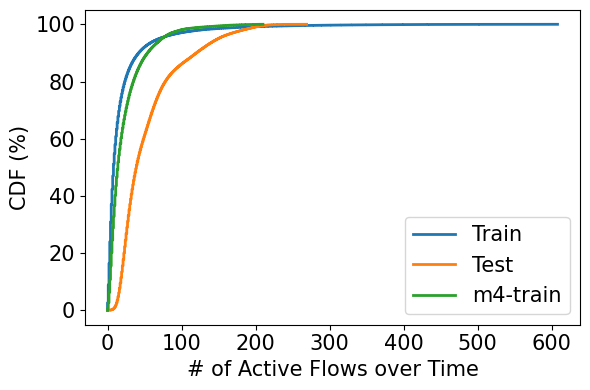

In [9]:
plt.figure(figsize=(6, 4))
legend_list=["Train","Test","m4-train"]
for i,res_n_flows_active in enumerate(res_total):
# Combine all active flow counts across scenarios into one array
    all_active_flows = np.concatenate(res_n_flows_active)

    # Sort the active flow counts
    sorted_flows = np.sort(all_active_flows)

    # Compute the CDF
    cdf = np.arange(1, len(sorted_flows) + 1) / len(sorted_flows)

    # Plot the CDF
    plt.plot(sorted_flows, cdf * 100, label=legend_list[i], linewidth=2)
plt.xlabel('# of Active Flows over Time', fontsize=15)
plt.ylabel('CDF (%)', fontsize=15)
# plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=15)
# plt.xscale("log")
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()  

(171168,)
(1146400,)
(184556,)


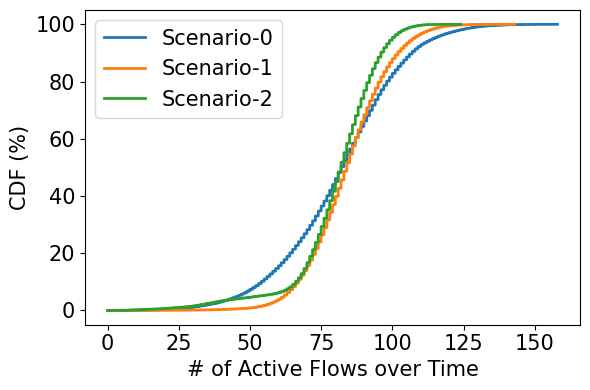

In [34]:

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data"
topo_type="_topology_flows"
res_n_flows_active=[]

# Plot the CDF
plt.figure(figsize=(6, 4))
for scenario_idx in range(3):
    dir_input_tmp = f"{dir_input}/{scenario_idx}/ns3"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    
    arrival_events = np.column_stack((fat, np.ones_like(fat)))  # +1 for each arrival
    completion_events = np.column_stack((fct, -np.ones_like(fct)))  # -1 for each completion

    # Combine events and sort by time
    all_events = np.vstack((arrival_events, completion_events))
    all_events = all_events[all_events[:, 0].argsort()]  # Sort by time
    
    times = all_events[:, 0]
    flow_changes = all_events[:, 1]
    active_flows = np.cumsum(flow_changes)

    all_active_flows=np.array(active_flows)
    print(all_active_flows.shape)

    # Sort the active flow counts
    sorted_flows = np.sort(all_active_flows)

    # Compute the CDF
    cdf = np.arange(1, len(sorted_flows) + 1) / len(sorted_flows)
    
    plt.plot(sorted_flows, cdf * 100, label=f'Scenario-{scenario_idx}', linewidth=2)
plt.xlabel('# of Active Flows over Time', fontsize=15)
plt.ylabel('CDF (%)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [31]:

def process_events(all_events):
    link_to_graph = {}  # Map each link to its graph ID
    link_to_nflows = defaultdict(int)  # Track active flow counts for each link
    graph_flow_count = defaultdict(int)  # Track active flow counts for each graph ID
    next_graph_id = 0  # Unique graph ID counter
    active_flows_over_time = []  # Store results

    for event_time, flow_change, links in all_events:
        # Find all graph IDs associated with the current links
        graph_ids = {link_to_graph[link] for link in links if link in link_to_graph and link_to_nflows[link] > 0}

        if flow_change == 1:  # Flow arrival
            if not graph_ids:
                # No overlapping graphs, assign a new graph ID
                new_graph_id = next_graph_id
                next_graph_id += 1
            else:
                # Merge all graph IDs into one
                new_graph_id = min(graph_ids)
                for graph_id in graph_ids:
                    if graph_id != new_graph_id:
                        # Reassign links to the merged graph ID
                        for link, gid in list(link_to_graph.items()):
                            if gid == graph_id:
                                link_to_graph[link] = new_graph_id
                        # Merge flow counts
                        graph_flow_count[new_graph_id] += graph_flow_count[graph_id]
                        del graph_flow_count[graph_id]

            for link in links:
                link_to_graph[link] = new_graph_id
                link_to_nflows[link] += 1
            graph_flow_count[new_graph_id] += 1
            active_flows_over_time.append(graph_flow_count[new_graph_id])
        else:  # Flow completion
            if not graph_ids:
                print(f"Warning: No graph ID found for links: {links}")
                continue
            graph_id = next(iter(graph_ids))
            graph_flow_count[graph_id] -= 1

            if graph_flow_count[graph_id] >0:
                active_flows_over_time.append(graph_flow_count[graph_id])
            else:
                del graph_flow_count[graph_id]
            for link in links:
                link_to_nflows[link] -= 1
                if link_to_nflows[link] == 0:
                    del link_to_graph[link]
    return active_flows_over_time


def plot_cdf(data, labels, xlabel, ylabel, title=""):
    plt.figure(figsize=(6, 4))
    for i, values in enumerate(data):
        values=np.concatenate(values)
        sorted_values = np.sort(values)
        cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
        plt.plot(sorted_values, cdf * 100, label=labels[i], linewidth=2)

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend(fontsize=15)
    plt.tick_params(axis="both", which="major", labelsize=15)
    if title:
        plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()


res_total = []
dir_input = "/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_train"
topo_type = "_topology_flows"
data_list = []
sampled_list = np.random.choice(np.arange(4000), 1000, replace=False)
# sampled_list = np.arange(4000)
for shard in sampled_list:
    for n_flows in [2000]:
        for n_hosts in [32]:
            for sample in [0]:
                topo_type_cur = topo_type
                spec = f"{shard}/ns3"
                try:
                    fid = np.load(f"{dir_input}/{spec}/fid{topo_type_cur}.npy")
                    if (
                        len(fid) == len(set(fid))
                        and np.all(fid[:-1] <= fid[1:])
                        and len(fid) % n_flows == 0
                    ):
                        data_list.append((spec, (0, n_hosts - 1), topo_type_cur))
                    # else:
                    #     print(f"{spec}: {len(fid)}")
                except:
                    continue

print(len(data_list))

res_n_flows_active = []
for spec_idx, (spec, src_dst_pair_target, topo_type) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat + np.load(f"{dir_input_tmp}/fct{topo_type}.npy")

    link_info = np.load(f"{dir_input_tmp}/flow_to_path.npy", allow_pickle=True)

    # Create arrival and completion events
    arrival_events = [(fat[i], 1, set(link_info[i])) for i in range(len(fat))]
    completion_events = [(fct[i], -1, set(link_info[i])) for i in range(len(fct))]

    # Combine and sort events by time
    all_events = sorted(arrival_events + completion_events, key=lambda x: x[0])

    active_flows_over_time = process_events(all_events)
    res_n_flows_active.append(active_flows_over_time)

res_total.append(res_n_flows_active)

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_test_8k"
topo_type="_topology_flows"
data_list=[]
for shard in np.arange(100):
    for n_hosts in [32]:
        spec=f"{shard}/ns3"
        fid_path=f"{dir_input}/{spec}/fid{topo_type}.npy"
        if os.path.exists(fid_path):
            fid = np.load(f"{dir_input}/{spec}/fid{topo_type}.npy")
            if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]):
                data_list.append((spec,(0,n_hosts-1),topo_type))
            # else:
            #     print(f"{spec}: {len(fid)}")
               
print(len(data_list))

res_n_flows_active=[]
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    
    link_info = np.load(f"{dir_input_tmp}/flow_to_path.npy", allow_pickle=True)

    # Create arrival and completion events
    arrival_events = [(fat[i], 1, set(link_info[i])) for i in range(len(fat))]
    completion_events = [(fct[i], -1, set(link_info[i])) for i in range(len(fct))]

    # Combine and sort events by time
    all_events = sorted(arrival_events + completion_events, key=lambda x: x[0])

    active_flows_over_time = process_events(all_events)
    res_n_flows_active.append(active_flows_over_time)
   
res_total.append(res_n_flows_active)

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_train"
data_path="/data2/lichenni/output_perflow/final_param_shard4000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/data_list.json"
data_list=json.load(open(data_path))
data_list=data_list["train"]
flow_size_threshold=100000000
res_n_flows_active=[]
for spec_idx,(spec,src_dst_pair_target,topo_type,segment_id,_) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    busy_periods=np.load(
        f"{dir_input_tmp}/period{topo_type}_t{flow_size_threshold}.npy",
        allow_pickle=True,
    )
    fid=np.array(busy_periods[segment_id])
    
    fat = np.load(f"{dir_input_tmp}/fat.npy")[fid]
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')[fid]
    
    link_info = np.load(f"{dir_input_tmp}/flow_to_path.npy", allow_pickle=True)

    # Create arrival and completion events
    arrival_events = [(fat[i], 1, set(link_info[i])) for i in range(len(fat))]
    completion_events = [(fct[i], -1, set(link_info[i])) for i in range(len(fct))]

    # Combine and sort events by time
    all_events = sorted(arrival_events + completion_events, key=lambda x: x[0])

    active_flows_over_time = process_events(all_events)
    res_n_flows_active.append(active_flows_over_time)
    
res_total.append(res_n_flows_active)


981
94


981
94
3600


/tmp/ipykernel_1413689/695379762.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


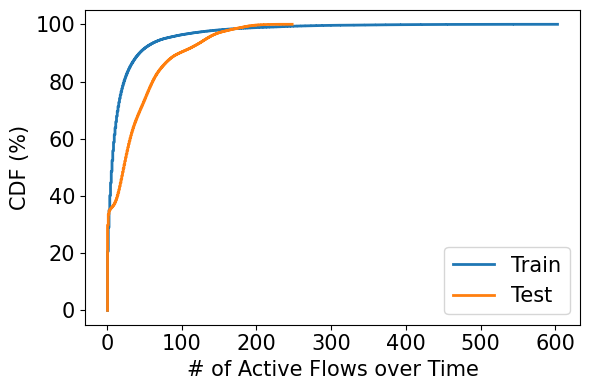

In [33]:
for tmp in res_total:
    print(len(tmp))
res_total=[res_total[0],res_total[1]]
plot_cdf(
    res_total,
    ["Train", "Test", "m4-train"],
    "# of Active Flows over Time",
    "CDF (%)",
)

(125887,)
(832976,)
(131504,)


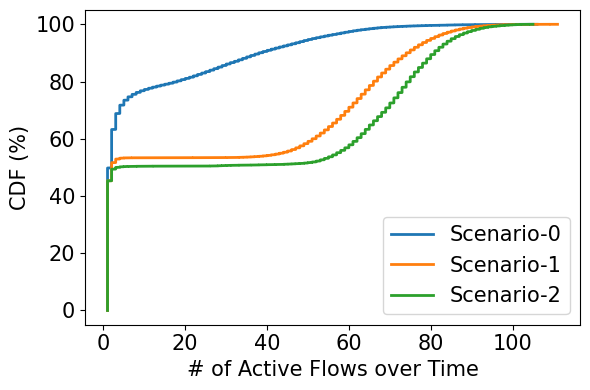

In [34]:

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data"
topo_type="_topology_flows"
res_n_flows_active=[]

# Plot the CDF
plt.figure(figsize=(6, 4))
for scenario_idx in range(3):
    dir_input_tmp = f"{dir_input}/{scenario_idx}/ns3"
    fat = np.load(f"{dir_input_tmp}/fat.npy")
    fct = fat+np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    
    link_info = np.load(f"{dir_input_tmp}/flow_to_path.npy", allow_pickle=True)
    
    # Create arrival and completion events
    arrival_events = [(fat[i], 1, set(link_info[i])) for i in range(len(fat))]
    completion_events = [(fct[i], -1, set(link_info[i])) for i in range(len(fct))]

    # Combine and sort events by time
    all_events = sorted(arrival_events + completion_events, key=lambda x: x[0])

    all_active_flows = process_events(all_events)
    all_active_flows=np.array(all_active_flows)
    print(all_active_flows.shape)
    
    # Sort the active flow counts
    sorted_flows = np.sort(all_active_flows)

    # Compute the CDF
    cdf = np.arange(1, len(sorted_flows) + 1) / len(sorted_flows)
    
    plt.plot(sorted_flows, cdf * 100, label=f'Scenario-{scenario_idx}', linewidth=2)
plt.xlabel('# of Active Flows over Time', fontsize=15)
plt.ylabel('CDF (%)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()